## Import Models

In [9]:
#import required libraries — we do need the models, flatten, dense, input layers 
import sys
import cv2
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## 2. Import dataset

In [10]:
# Path for train, validation and test datasets
sys.path.append('../elpv-dataset/utils')
from elpv_reader import load_dataset
images, probs, types = load_dataset()

IMAGE_SIZE = [224, 224] #Default image size for VGG19

import numpy as np
import pandas as pd

print(images.shape,probs.shape,types.shape)

# Define degradation categories based on labels
def categorize_labels(labels):
    categories = []
    for label in labels:
        if label == 0 :
            categories.append(0)
        elif label >= 0.32 and label <= 0.34:
            categories.append(1)
        elif label >= 0.65 and label <= 0.67:
            categories.append(2)
        else:
            categories.append(3)
    return categories

class_labels = categorize_labels(probs)
print(class_labels)
print(max(class_labels)+1)

(2624, 300, 300) (2624,) (2624,)
[3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 2, 0, 0, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 3, 3, 1, 1, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 1, 1, 0, 3, 3, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 2, 2, 2, 3, 3, 2, 3, 2, 2, 0, 1, 3, 3, 0, 3, 3, 3, 2, 1, 0, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 0, 0, 3, 0, 3, 3, 3, 3, 1, 3, 0, 1, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 3, 

# Validation and Image Dataset
## Move Images to sorted folders for keras processing ##

In [11]:
import os
import shutil
from PIL import Image

# Set the path to your source folder containing all images
source_folder = '../elpv-dataset/images'

# Set the path to your destination folder where you want to organize images by class
destination_folder = '../elpv-dataset/sorted'

# Create destination folders if they don't exist
for class_index in range(4):  # Assuming you have 4 classes
    class_folder = os.path.join(destination_folder, str(class_index))
    os.makedirs(class_folder, exist_ok=True)

# List all image files in the source folder
image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

# Read the class labels from your list

# Organize images by copying them to their respective class folders
for image_file, class_label in zip(image_files, class_labels):
    class_label = int(class_label)
    source_path = os.path.join(source_folder, image_file)
    destination_path = os.path.join(destination_folder, str(class_label), image_file)
 
 # Open the image using Pillow
    try:
        image = Image.open(source_path)
    except Exception as e:
        print(f"Error opening image {source_path}: {e}")
        continue

    # Resize the image (replace (width, height) with the desired size)
    resized_image = image.resize(IMAGE_SIZE)
    # Save the resized image to the destination path
    resized_image.save(destination_path)
    # Optionally, close the image
    image.close()

print("Images organized successfully!")



Images organized successfully!


## Add into training data set structure

In [12]:
data_dir = '../elpv-dataset/sorted/'
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print(train_ds)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2624 files belonging to 4 classes.
Using 2100 files for training.
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Found 2624 files belonging to 4 classes.
Using 524 files for validation.


In [13]:
#Convert layers to one hot encoding?
from keras.utils import to_categorical

# Assuming labels is your original list of labels
one_hot_labels = to_categorical(class_labels, num_classes=4)

In [10]:
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(4, activation='softmax')(x)
#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [11]:
#Compile the model 
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

Epoch 1/20


66/66 [==============================] - 16s 233ms/step - loss: 4.6768 - accuracy: 0.6248 - val_loss: 2.9311 - val_accuracy: 0.6870
Epoch 2/20
66/66 [==============================] - 15s 230ms/step - loss: 2.0037 - accuracy: 0.7495 - val_loss: 3.8788 - val_accuracy: 0.5935
Epoch 3/20
66/66 [==============================] - 15s 230ms/step - loss: 1.4216 - accuracy: 0.8010 - val_loss: 2.9694 - val_accuracy: 0.6603
Epoch 4/20
66/66 [==============================] - 15s 227ms/step - loss: 1.0091 - accuracy: 0.8514 - val_loss: 2.9973 - val_accuracy: 0.7214
Epoch 5/20
66/66 [==============================] - 15s 226ms/step - loss: 0.9908 - accuracy: 0.8557 - val_loss: 2.8488 - val_accuracy: 0.6469
Epoch 6/20
66/66 [==============================] - 15s 233ms/step - loss: 0.4580 - accuracy: 0.9181 - val_loss: 2.8894 - val_accuracy: 0.7405
Epoch 7/20
66/66 [==============================] - 15s 228ms/step - loss: 0.4064 - accuracy: 0.9352 - val_loss: 3.1775 - val_accuracy: 0.6870
Epoch 8/20

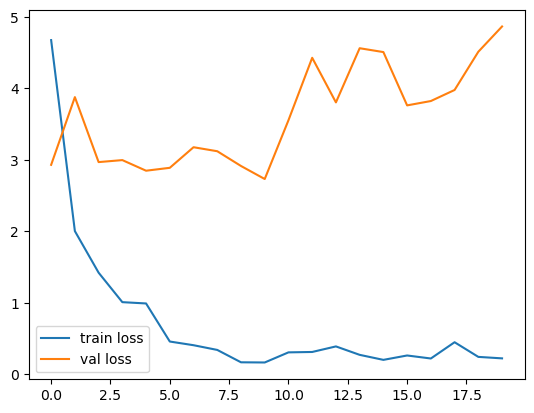

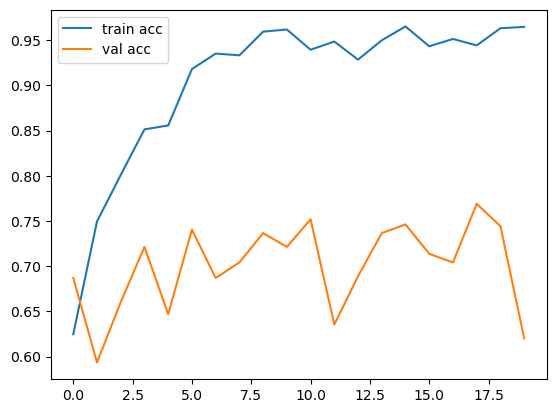

In [12]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()




ResNet152V2

In [15]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
resnet = ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in resnet.layers:
  layer.trainable = False

x2 = Flatten()(resnet.output) #Output obtained on vgg16 is now flattened. 
prediction2 = Dense(4, activation='softmax')(x2)
#Creating model object 
model2 = Model(inputs=resnet.input, outputs=prediction2)
model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
#Compile the model 
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=32)

Epoch 1/20
66/66 [==============================] - 22s 272ms/step - loss: 25.2220 - accuracy: 0.4471 - val_loss: 20.0144 - val_accuracy: 0.5515
Epoch 2/20
66/66 [==============================] - 16s 242ms/step - loss: 24.9822 - accuracy: 0.4543 - val_loss: 17.3133 - val_accuracy: 0.6240
Epoch 3/20
66/66 [==============================] - 16s 241ms/step - loss: 24.2607 - accuracy: 0.4714 - val_loss: 34.0115 - val_accuracy: 0.2615
Epoch 4/20
66/66 [==============================] - 16s 237ms/step - loss: 23.2754 - accuracy: 0.4900 - val_loss: 16.9618 - val_accuracy: 0.6317
Epoch 5/20
66/66 [==============================] - 16s 237ms/step - loss: 21.8807 - accuracy: 0.5210 - val_loss: 17.2606 - val_accuracy: 0.6240
Epoch 6/20
66/66 [==============================] - 16s 237ms/step - loss: 21.3050 - accuracy: 0.5348 - val_loss: 15.0191 - val_accuracy: 0.6698
Epoch 7/20
66/66 [==============================] - 16s 237ms/step - loss: 21.3232 - accuracy: 0.5352 - val_loss: 15.4834 - val_ac

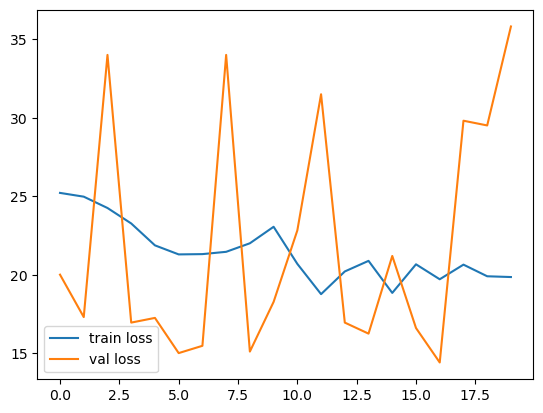

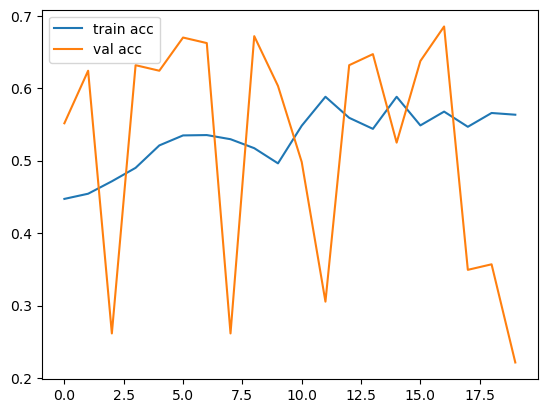

In [17]:
# loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()